In [ ]:
import pickle
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
from tensorflow import keras

from src.cfd import CFD
from src.dataset import X_TIME, load_expanded_dataset_train_val, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_all_ch
from src.network_utils import train_model as _base_train_model, gaussian_kernel, plot_difference_hist

PWD = '../../..'
sys.path.append(PWD)

OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

In [ ]:
BASE_CFD_THRESHOLD = 0.2
CFD_N_BASELINE = 6

base_cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=BASE_CFD_THRESHOLD)

In [ ]:
N_BASELINE = 6

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 10
BATCH_SIZE = 2048
LOSS_WEIGHT = 1000

ES_PATIENCE = 5
LR_PATIENCE = 50

In [ ]:
train_dataset, val_dataset = load_expanded_dataset_train_val(PWD)
train_dataset[0].shape, val_dataset[0].shape

((26719,), (6680,))

In [ ]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

cfd_by_channel = {(p, ch): CFD(n_baseline=N_BASELINE, threshold=thresh) for (p, ch), thresh in
                  optimal_cfd_thresholds.items()}

Optimal thresholds:
(1,  2): 0.180
(1, 11): 0.185
(2,  2): 0.220
(2, 11): 0.145
(3,  2): 0.130
(3, 11): 0.175


# Utils

In [54]:
def compute_true_t(t_avg: float, t_ch: float, t_0: float) -> float:
    # use only timestamps from other channels
    return ((3 * t_avg) - (t_ch + t_0)) / 2 - t_0


def compute_true_dataset(model: CFD | keras.Model, dataset_t_avg: np.ndarray, dataset_wav: dict,
                         dataset_t0: dict) -> dict:
    true_dataset = defaultdict(list)
    for key in dataset_wav.keys():
        if isinstance(model, CFD):
            t_pred_array = model.predict(X_TIME, dataset_wav[key])
        else:
            t_pred_array_original = model.predict(dataset_wav[key], batch_size=BATCH_SIZE)
            # UNet
            t_pred_array = np.empty(t_pred_array_original.shape[0])
            for i, y in enumerate(t_pred_array_original):
                _, t_pred_array[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

        for i, t_avg in enumerate(dataset_t_avg):
            if np.isnan(dataset_t0[key][i]):
                true_dataset[key].append(np.nan)
            else:
                t_0 = dataset_t0[key][i]
                t_pred = t_pred_array[i]
                true_dataset[key].append(compute_true_t(t_avg, t_pred, t_0))

    return true_dataset


def build_nn_dataset(dataset_wav: dict, dataset_true: dict) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    x, y = [], []
    for key, data in dataset_wav.items():
        t_data = dataset_true[key]
        for i in range(len(t_data)):
            if np.isnan(t_data[i]):
                continue
            wav = data[i]
            true_t = t_data[i]

            x.append(wav)
            y.append(true_t)

    x, y = np.array(x), np.array(y)

    # UNet
    y_network = np.array([gaussian_kernel(t) for t in y])

    return x, y, y_network


def build_and_train_network(iteration: int, x_train: np.ndarray, x_val: np.ndarray, y_train: np.ndarray,
                            y_val: np.ndarray, train: bool = True,
                            verbose: int = 2) -> tuple[keras.Model, pd.DataFrame]:
    model = optimal_model_builder_all_ch()
    name = f"optimal_it_{iteration}"
    history = _base_train_model(model, name, "iti_experiments", x_train, y_train, x_val, y_val, LR, train, N_EPOCHS,
                                verbose, BATCH_SIZE, LR_PATIENCE, ES_PATIENCE, ES_MIN_DELTA, LOSS_WEIGHT,
                                root=PWD + '/data')
    return model, history


def pred_model(model: keras.Model, x: np.ndarray) -> np.ndarray:
    y_pred = model.predict(x, batch_size=BATCH_SIZE)

    # UNet
    y_pred_t = np.empty(y_pred.shape[0])
    for i, y in enumerate(y_pred):
        _, y_pred_t[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred_t


def evaluate_model_wrt_cfd_average(model: keras.Model, x: np.ndarray, y_true_t: np.ndarray, show: bool = True) -> float:
    y_pred = pred_model(model, x)
    std, _, _ = plot_difference_hist(y_true_t, y_pred, show=show)
    return std

In [ ]:
true_cfd_train = compute_true_dataset(base_cfd, *train_dataset)
true_cfd_val = compute_true_dataset(base_cfd, *val_dataset)
x_train, y_train_t, y_train = build_nn_dataset(train_dataset[1], true_cfd_train)
x_val, y_val_t, y_val = build_nn_dataset(val_dataset[1], true_cfd_val)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

C:\Repository\pps-timing-ml-sampic\src\cfd.py:63: RuntimeWarning: invalid value encountered in divide
  samples /= np.max(samples)


((80157, 24), (20040, 24), (80157, 24), (20040, 24))

# Test

## Iteration 1

In [40]:
# 1.1 train model
model, _ = build_and_train_network(iteration=0, x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val, train=False)

10/10 [==============================] - 1s 55ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


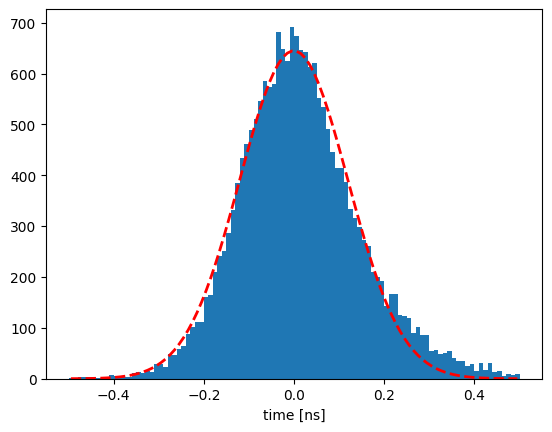

Iteration 1. std wrt. CFD average: 119.90 ps


In [42]:
# 1.2 Evaluate wrt CFD averages
std = evaluate_model_wrt_cfd_average(model, x_val, y_val_t)
print(f"Iteration 1. std wrt. CFD average: {std * 1000:0.2f} ps")

In [44]:
# 1.3 Evaluate pairwise precision

In [52]:
# 1.4 Update dataset
def build_updated_dataset(model: keras.Model, dataset: tuple[np.ndarray, dict, dict]) -> tuple[np.ndarray, dict, dict]:
    _, dataset_wav, dataset_t0 = dataset
    dataset_t0_updated = {}
    dataset_len = list(dataset_wav.values())[0].shape[0]
    dataset_avg = np.zeros(dataset_len)
    dataset_avg_count = np.zeros(dataset_len)

    for key in dataset_wav.keys():
        print(f'Processing channel {key}...')
        # compute updated t0
        wav_array = dataset_wav[key]
        t0_array = dataset_t0[key].copy()

        t_pred_array = pred_model(model, wav_array)

        mask = ~np.isnan(t0_array)
        t0_temp = t0_array[mask]
        t_pred_array_temp = t_pred_array[mask]

        t_fixed = t0_temp + t_pred_array_temp
        t_mean = np.mean(t_fixed)

        t0_array[mask] -= t_mean
        dataset_t0_updated[key] = t0_array

        # add to avg
        dataset_avg[mask] += t0_array[mask]
        dataset_avg_count[mask] += 1

    dataset_avg /= dataset_avg_count

    return dataset_avg, dataset_wav, dataset_t0_updated


# TODO: Analyse together
train_dataset_it1 = build_updated_dataset(model, train_dataset)
val_dataset_it1 = build_updated_dataset(model, val_dataset)

Processing channel (1, 2)
14/14 [==============================] - 1s 38ms/step
Processing channel (1, 11)
14/14 [==============================] - 1s 48ms/step
Processing channel (2, 2)
14/14 [==============================] - 1s 38ms/step
Processing channel (2, 11)
14/14 [==============================] - 0s 22ms/step
Processing channel (3, 2)
14/14 [==============================] - 1s 39ms/step
Processing channel (3, 11)
14/14 [==============================] - 0s 34ms/step
Processing channel (1, 2)
4/4 [==============================] - 0s 110ms/step
Processing channel (1, 11)
4/4 [==============================] - 0s 20ms/step
Processing channel (2, 2)
4/4 [==============================] - 0s 40ms/step
Processing channel (2, 11)
4/4 [==============================] - 0s 99ms/step
Processing channel (3, 2)
4/4 [==============================] - 0s 20ms/step
Processing channel (3, 11)
4/4 [==============================] - 0s 68ms/step


In [55]:
true_t_train_it1 = compute_true_dataset(model, *train_dataset_it1)
true_t_val_it1 = compute_true_dataset(model, *val_dataset_it1)
x_train_it1, y_train_t_it1, y_train_it1 = build_nn_dataset(train_dataset_it1[1], true_t_train_it1)
x_val, y_val_t, y_val = build_nn_dataset(val_dataset_it1[1], true_t_val_it1)
x_train_it1.shape, y_train_it1.shape, x_val.shape, y_val.shape

4/4 [==============================] - 0s 100ms/step


((80157, 24), (80157, 24), (20040, 24), (20040, 24))